# Feature Engineering
In this section you'll learn the following topics:
- How to create features for timeseries data
- How to build functions that can help you generate a ton of features with little code
- How to make your functions testable so that you can guarantee expected behavior
- Bonus: implement your own `scikit-learn` pipeline to do some data transformation

## Load your dataset
We'll use the dataset from previous exercise, load the dataset in memory and call it `df`. If you have more than 2000 rows, go back and check if you wrote the output correctly.
- Are the data types correct? If so, how come?

In [37]:
import pandas as pd
df = pd.read_parquet('data/ex_1.parquet')

In [38]:
# The data types are correct because parquet stores schema information
df.dtypes

power    float64
dtype: object

# Create helper functions
In this section you'll create helper functions that can generate a bunch of features for you. Since we're doing timeseries forecasting we are especially interested in features that are derived from the target variable and the time column.

## Datetime features
Create a function `create_datetime_features` that, takes in a dataframe with a datetime index and produces the following derived columns:
- Day of week
- Week
- Month
- Quarther
- Year

In [39]:
def create_datetime_features(df) -> df:
    return df.assign(
        day_of_week = lambda df: df.index.day_name(),
        week = lambda df: df.index.isocalendar().week,
        month = lambda df: df.index.month,
        quarter = lambda df: df.index.quarter,
        year = lambda df: df.index.year
    )

## Testing your function
In data- and software engineering it's considered a best practice to write tests for your code. Tests are simple pieces of code that run a function and assert if everything is as expected. In practice you'll use a testing framework to evaluate your code. However, the basis remains the same - writing assert statements. 

We need to write a test for the function `create_datetime_features`, we can do so by writing a new function called: `test_create_datetime_features`. In this function you'll need to do the following things:
- Create a dummy dataframe with a datetime index and two rows. You can set the start and end date of the index to something you'll like, it must be on day level
- Call your function `create_datetime_features` with this dummy dataframe, you expect a specific outcome. This is what we'll be testing. Assign this result to a variable in side your test function
- Test the following things using `assert`:
    - The shape of the output data frame, it should contain all the columns
    - Some values from each column
- Call your function `test_create_datetime_features()`, if all goes well you should get no errors. You can deliberately make a wrong assert statement to see what happens when the test fails. 

In [40]:
def test_create_datetime_features():
    dummy_df = pd.DataFrame([], index=pd.date_range('2022-02-01', '2022-02-02', periods=2))
    
    dummy_df_features = create_datetime_features(dummy_df)
    
    print(f"The dataframe shape is: {dummy_df_features.shape}")
    assert dummy_df_features.shape == (2, 5)
    assert dummy_df_features.loc['2022-02-01', 'year'] == 2022
    
test_create_datetime_features()

The dataframe shape is: (2, 5)


---

# Windows and moving aggregates

To have a better idea of the trend, we can make use of window functions. Essentially we'll compute a moving average over a period to filter out noise. Window functions perform calculations on a set of rows that are related together. But, unlike the aggregate functions, windowing functions do not collapse the result of the rows into a single value. Instead, all the rows maintain their original identity and the calculated result is returned for every row.

- What kind of effect does the window size have?
- What is the disadvantage of using a moving average?
- Implement a 14 day moving average in pandas. Plot this together with the daily power consumption.
- What choices do you need to make when creating a window function? There are three important components (not including the column choice). 

<AxesSubplot:xlabel='datetime'>

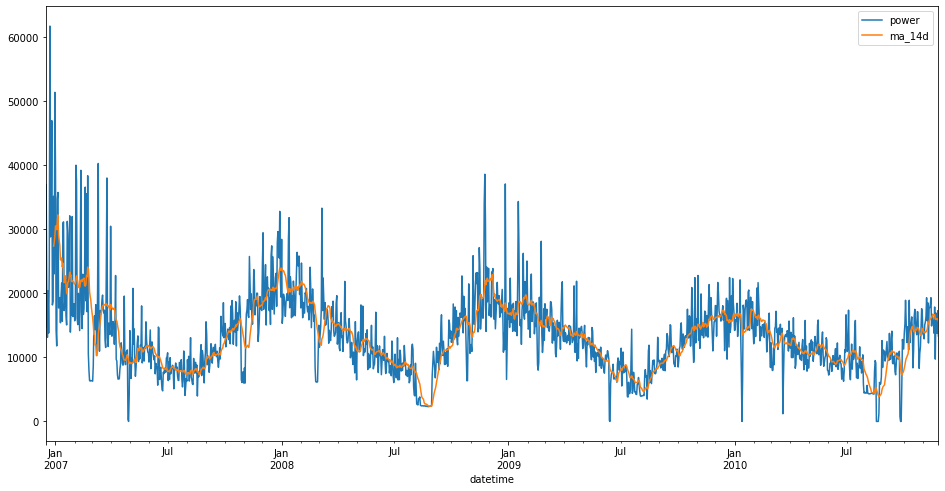

In [41]:
# The larger the window, the less effect a single data point has
# Moving averages by definition lag behind. Especially if you don't center them.
# Choices: window size, aggregation metric, centering

df.assign(
    ma_14d = lambda df: df['power'].rolling(14, center=False).mean()
)[['power', 'ma_14d']].plot(figsize=(16,8))

## Weighting datapoints
One can imagine that more recent data can be more important than data points that are further back in time. What kind of alternative for the moving average can you think of?
- Implement this in pandas
- Add it to the plot
- What difference do you see?

<AxesSubplot:xlabel='datetime'>

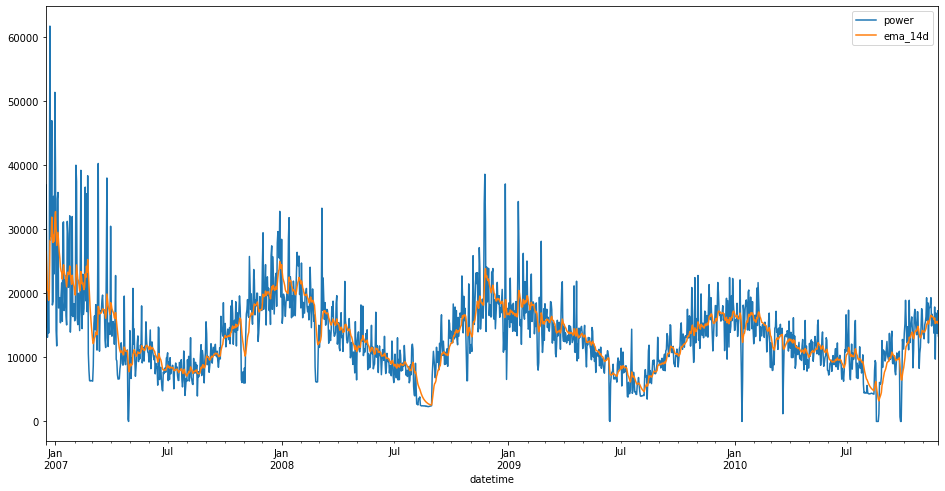

In [42]:
# EWM
df.assign(
    ema_14d = lambda df: df['power'].ewm(span=14).mean()
)[['power', 'ema_14d']].plot(figsize=(16,8))

# The difference is that the exponential moving average put more weight recent data points.
# See dip around July 2008 which is different. 

## Expanding windows
Investigate what expanding windows are in Pandas
- When would you use something like this?
- Can you implement an expanding window that computes the total daily power used?

<AxesSubplot:xlabel='datetime'>

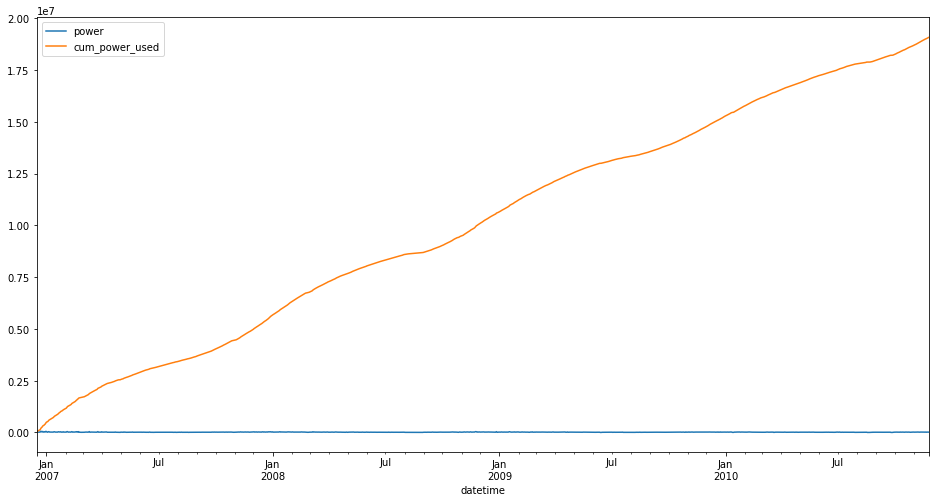

In [43]:
# Sum
df.assign(
    cum_power_used = lambda df: df['power'].expanding().sum()
)[['power', 'cum_power_used']].plot(figsize=(16,8))

<AxesSubplot:xlabel='datetime'>

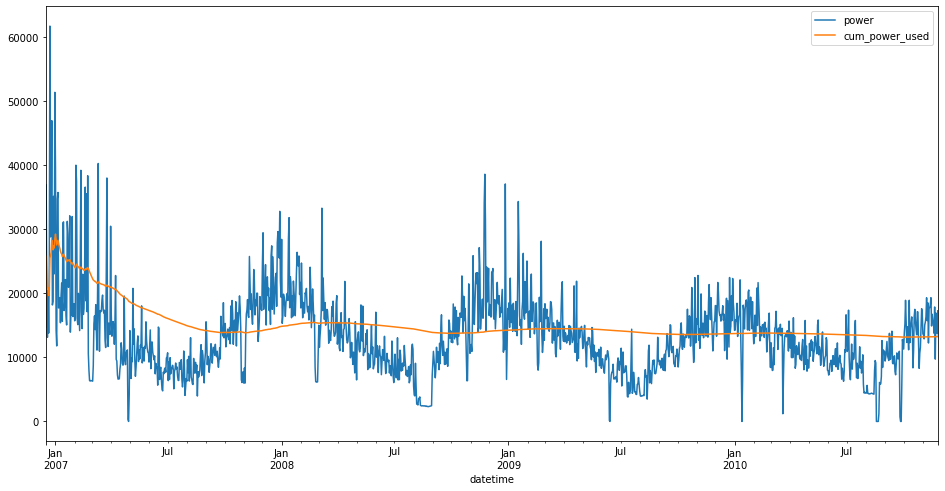

In [20]:
# Mean
df.assign(
    cum_power_used = lambda df: df['power'].expanding().mean()
)[['power', 'cum_power_used']].plot(figsize=(16,8))

## Calculating lags as features
In this section you'll compute a few features that are derived from the target variable column. Derived features can be a powerful thing in timeseries forecasting. I advise to try to write a function that can do the different computations for you. Making clever use of loops can save you a bunch of time. In addition, your code will be testable which makes it easier to bring something to production.

We'll consider the following type of features:
- Lags (values of previous day)
- Windowed values (aggregated values over a certain period)

Try to add the following features to your data frame, base the features on your `power` column:
- Add lags for 1 to 14 days ago (14 columns)
- Add windows for the mean, and variance with different timespans: 7, 14, 21, 28, 35 (10 columns). Make the input configurable.
- Plot the result

In [44]:
def create_lags(df: pd.DataFrame, lags: list, feature_column: str):
    for lag in lags:
        df['power_lag_{}'.format(lag)] = df[feature_column].shift(lag)
    
    return df

In [45]:
def create_windows(df: pd.DataFrame, windows: list, feature_column: str):
    for span in windows:
        df['power_ma_{}'.format(span)] = df[feature_column].rolling(span, center=False).mean()
        df['power_var_{}'.format(span)] = df[feature_column].rolling(span, center=False).var()
    
    return df

In [46]:
df = create_lags(df, range(1,3), 'power')

In [47]:
df = create_windows(df, list(range(7, 36, 7)), 'power')

<AxesSubplot:xlabel='datetime'>

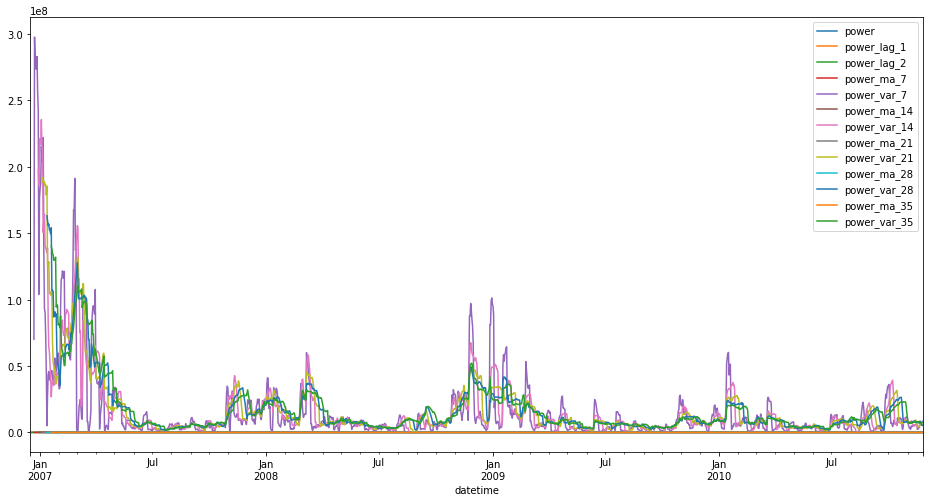

In [48]:
df.plot(figsize=(16,8))

## Missing values
Adding these lags could introduce missing values, make sure to deal with these before you continue.

In [49]:
# Since it's just a few data points, we might as well drop them. They're only located at the start of the data.
df = df.dropna(how='any')

---

# Bonus: Scikit-learn pipelines
If creating the functions was straightforward and you feel up to a challenge, implement your feature creation as `scikit-learn` pipeline objects. `Scikit-learn` pipeline objects are a great way to chain together a bunch of operations that allow you to build a model pipeline with blocks. 

These blocks are testable and follow the `scikit-learn` style. Pipelines allow you to create a single pipeline object that can do your data preprocessing and model fitting in one go. Additionally, it's easy to swap out or change components in the pipeline.

In [ ]:
# Your solution

---

## Other features
Can you add other features that you think are useful for predicting the power usage? Perhaps something to do with holidays or season. Feel free to add a bunch of features, we'll be using them in the final part. :)

In [ ]:
# Your solution

---

# Store prepared data
Store your prepared dataset as parquet. You'll need it in the next exercise.

In [50]:
# Your solution
df.to_parquet('data/ex_2.parquet')